# MNIST Digit Classification with Convolutional Neural Network (CNN)

**Discipline(s):** Computer Vision, Deep Learning

colab에서 돌릴 경우, 런타임 유형을 GPU로 변경해주세요.

## 1. Import Statements

---



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

## 2. Data Preprocessing

---



The first step is to preprocess our data.

In [2]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.13MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.19MB/s]


In [5]:
X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets

print("Training Images:", X_train.shape)  # [60000, 28, 28]
print("Testing Images:", X_test.shape)    # [10000, 28, 28]
print("Training Labels:", y_train.shape)  # [60000]
print("Test Labels:", y_test.shape)       # [10000]

Training Images: torch.Size([60000, 28, 28])
Testing Images: torch.Size([10000, 28, 28])
Training Labels: torch.Size([60000])
Test Labels: torch.Size([10000])


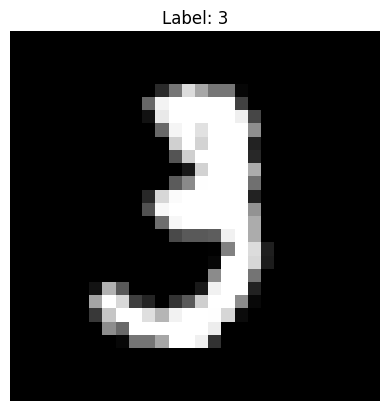

In [6]:
plt.imshow(X_train[10], cmap='gray')
plt.title(f"Label: {y_train[10].item()}")
plt.axis('off')
plt.show()

## 3. Convolutional Neural Network (CNN)

---



### 3.1. Define the Model

We then have to define our convolutional neural network.

In [10]:
# CNN 모델 정의 -> 차원이 어떻게 될지 생각하면서 코드 빈칸을 채워주세요.
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # fully connected layer 전, flatten 과정 필요
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(256*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
# 모델 준비
model = SimpleCNN().to(DEVICE)

Once our model is defined, we can compile it using the Adam optimizer and the categorical cross-entropy loss function.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### 3.2. Train the Model

In [13]:
def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (output.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [14]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item() * y.size(0)
            correct += (output.argmax(dim=1) == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [15]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.1622, Train Acc: 0.9480 | Test Loss: 0.0422, Test Acc: 0.9863
[Epoch 2] Train Loss: 0.0506, Train Acc: 0.9847 | Test Loss: 0.0250, Test Acc: 0.9924
[Epoch 3] Train Loss: 0.0365, Train Acc: 0.9887 | Test Loss: 0.0215, Test Acc: 0.9934
[Epoch 4] Train Loss: 0.0281, Train Acc: 0.9912 | Test Loss: 0.0222, Test Acc: 0.9926
[Epoch 5] Train Loss: 0.0229, Train Acc: 0.9925 | Test Loss: 0.0250, Test Acc: 0.9923
[Epoch 6] Train Loss: 0.0190, Train Acc: 0.9942 | Test Loss: 0.0270, Test Acc: 0.9919
[Epoch 7] Train Loss: 0.0172, Train Acc: 0.9947 | Test Loss: 0.0246, Test Acc: 0.9922
[Epoch 8] Train Loss: 0.0151, Train Acc: 0.9954 | Test Loss: 0.0142, Test Acc: 0.9955
[Epoch 9] Train Loss: 0.0124, Train Acc: 0.9959 | Test Loss: 0.0224, Test Acc: 0.9936
[Epoch 10] Train Loss: 0.0113, Train Acc: 0.9964 | Test Loss: 0.0187, Test Acc: 0.9934


### 3.3. 시각화

Finally, we can plot the curves.

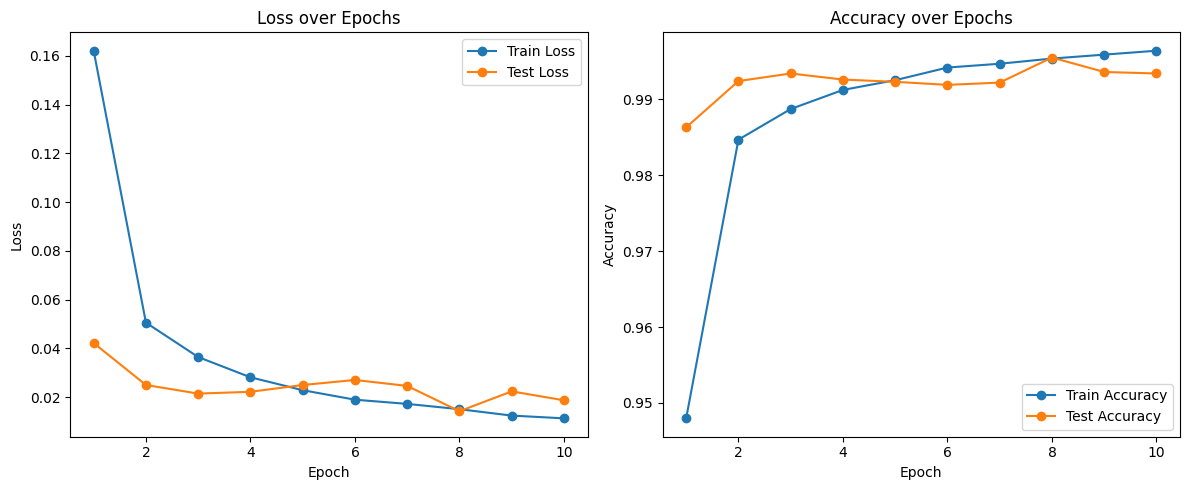

In [16]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [17]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

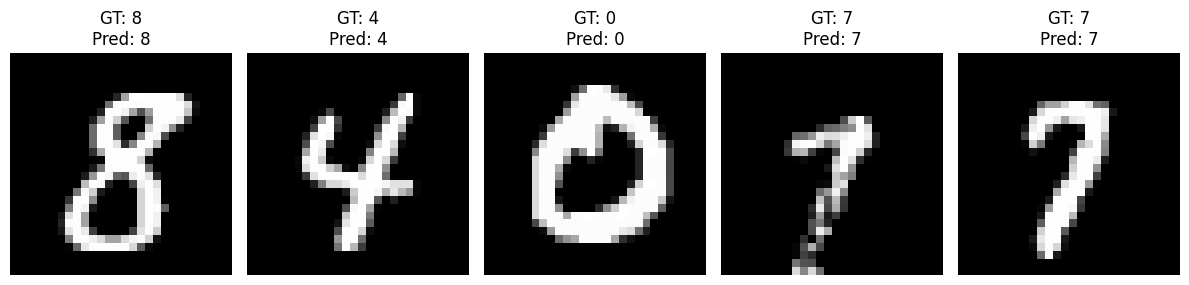

In [18]:
show_random_predictions(model, test_dataset, num_images=5)

## ResNet

In [151]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [152]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        # Skip connection: 채널 수가 다르면 어떤 convolution layer를 사용하는게 좋을지 생각해주세요.
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        return self.relu(out)

In [153]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # layer 등을 추가로 더 쌓으셔도 됩니다.
        self.layer1 = ResidualBlock(16, 32)
        self.layer2 = ResidualBlock(32, 64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 빈칸을 채워주세요.
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        # 빈칸을 채워주세요.
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [154]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # layer 등을 추가로 더 쌓으셔도 됩니다.
        self.layer1 = nn.Sequential(
            ResidualBlock(16, 16, stride=1),
            ResidualBlock(16, 32, stride=1),
            ResidualBlock(32, 32, stride=1),
            ResidualBlock(32, 64, stride=1),
            ResidualBlock(64, 64, stride=1)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1),
            ResidualBlock(128, 256, stride=1),
            ResidualBlock(256, 256, stride=1),
            ResidualBlock(256, 512, stride=1),
            ResidualBlock(512, 512, stride=1)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 빈칸을 채워주세요.
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [155]:
model = ResNetLike().to(DEVICE)

In [156]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [157]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.1379, Train Acc: 0.9569 | Test Loss: 0.0471, Test Acc: 0.9851
[Epoch 2] Train Loss: 0.0470, Train Acc: 0.9854 | Test Loss: 0.0342, Test Acc: 0.9888
[Epoch 3] Train Loss: 0.0353, Train Acc: 0.9892 | Test Loss: 0.0259, Test Acc: 0.9914
[Epoch 4] Train Loss: 0.0279, Train Acc: 0.9911 | Test Loss: 0.0469, Test Acc: 0.9842
[Epoch 5] Train Loss: 0.0220, Train Acc: 0.9927 | Test Loss: 0.0282, Test Acc: 0.9909
[Epoch 6] Train Loss: 0.0190, Train Acc: 0.9940 | Test Loss: 0.0271, Test Acc: 0.9915
[Epoch 7] Train Loss: 0.0149, Train Acc: 0.9953 | Test Loss: 0.0326, Test Acc: 0.9917
[Epoch 8] Train Loss: 0.0140, Train Acc: 0.9954 | Test Loss: 0.0227, Test Acc: 0.9928
[Epoch 9] Train Loss: 0.0126, Train Acc: 0.9959 | Test Loss: 0.0346, Test Acc: 0.9901
[Epoch 10] Train Loss: 0.0100, Train Acc: 0.9967 | Test Loss: 0.0267, Test Acc: 0.9926


### 시각화

Finally, we can plot the curves.

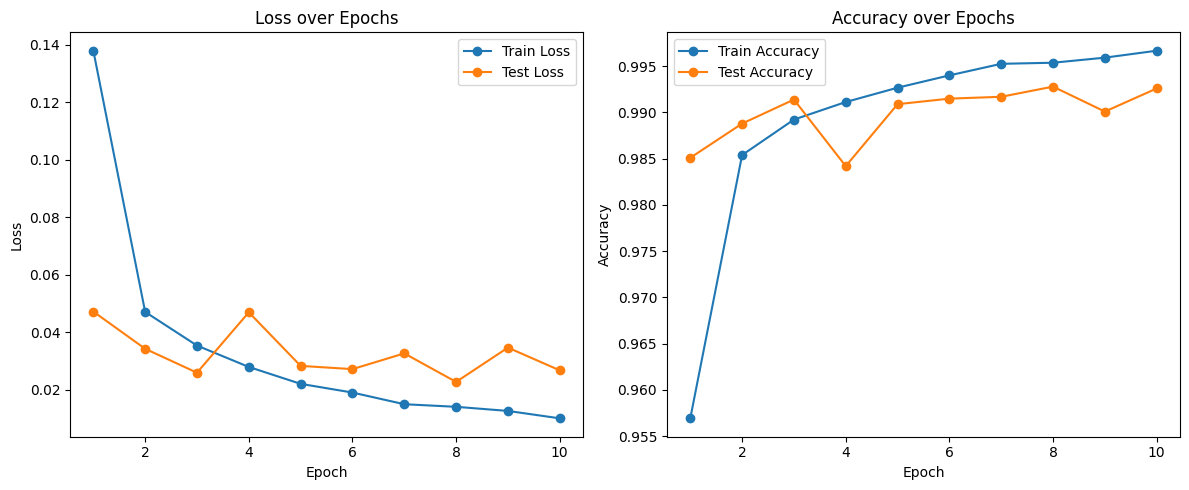

In [158]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [159]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

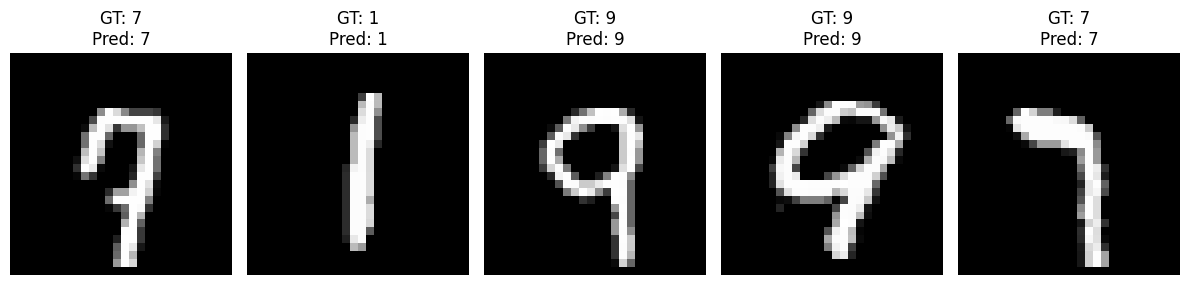

In [160]:
show_random_predictions(model, test_dataset, num_images=5)

# 다른 데이터셋으로도 진행해보기

In [165]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [166]:
FMNIST_MEAN = (0.2860,)
FMNIST_STD  = (0.3530,)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(FMNIST_MEAN, FMNIST_STD),
])

In [167]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets

In [168]:
model = ResNetLike().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [169]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.4308, Train Acc: 0.8429 | Test Loss: 0.3432, Test Acc: 0.8750
[Epoch 2] Train Loss: 0.2711, Train Acc: 0.9014 | Test Loss: 0.2851, Test Acc: 0.8940
[Epoch 3] Train Loss: 0.2179, Train Acc: 0.9202 | Test Loss: 0.2759, Test Acc: 0.9010
[Epoch 4] Train Loss: 0.1781, Train Acc: 0.9340 | Test Loss: 0.2755, Test Acc: 0.9028
[Epoch 5] Train Loss: 0.1421, Train Acc: 0.9484 | Test Loss: 0.2902, Test Acc: 0.9010
[Epoch 6] Train Loss: 0.1152, Train Acc: 0.9576 | Test Loss: 0.3169, Test Acc: 0.8995
[Epoch 7] Train Loss: 0.0920, Train Acc: 0.9659 | Test Loss: 0.3272, Test Acc: 0.9025
[Epoch 8] Train Loss: 0.0778, Train Acc: 0.9714 | Test Loss: 0.3270, Test Acc: 0.9040
[Epoch 9] Train Loss: 0.0661, Train Acc: 0.9755 | Test Loss: 0.3696, Test Acc: 0.9051
[Epoch 10] Train Loss: 0.0588, Train Acc: 0.9791 | Test Loss: 0.3825, Test Acc: 0.8984


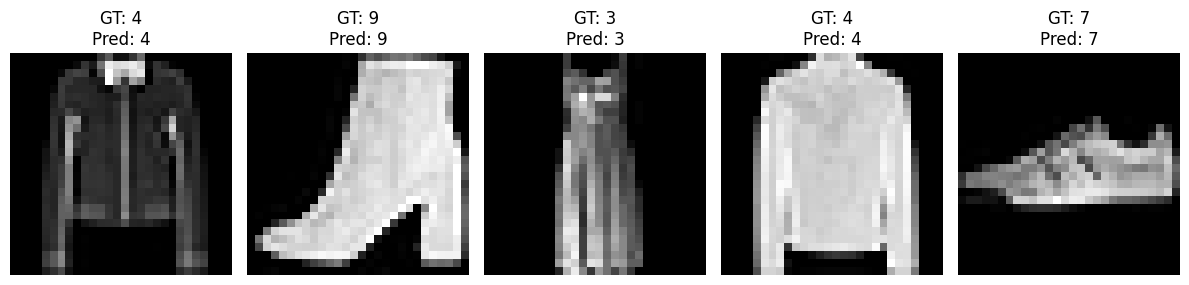

In [170]:
show_random_predictions(model, test_dataset, num_images=5)

[Epoch 1] Train Loss: 0.4646, Train Acc: 0.8262 | Test Loss: 0.3064, Test Acc: 0.8892
[Epoch 2] Train Loss: 0.2806, Train Acc: 0.8965 | Test Loss: 0.2943, Test Acc: 0.8920
[Epoch 3] Train Loss: 0.2338, Train Acc: 0.9134 | Test Loss: 0.2434, Test Acc: 0.9089
[Epoch 4] Train Loss: 0.2048, Train Acc: 0.9235 | Test Loss: 0.2187, Test Acc: 0.9190
[Epoch 5] Train Loss: 0.1785, Train Acc: 0.9329 | Test Loss: 0.2145, Test Acc: 0.9231
[Epoch 6] Train Loss: 0.1587, Train Acc: 0.9419 | Test Loss: 0.2168, Test Acc: 0.9255
[Epoch 7] Train Loss: 0.1420, Train Acc: 0.9472 | Test Loss: 0.2098, Test Acc: 0.9276
[Epoch 8] Train Loss: 0.1232, Train Acc: 0.9543 | Test Loss: 0.1983, Test Acc: 0.9308
[Epoch 9] Train Loss: 0.1099, Train Acc: 0.9582 | Test Loss: 0.2003, Test Acc: 0.9342
[Epoch 10] Train Loss: 0.0957, Train Acc: 0.9647 | Test Loss: 0.2075, Test Acc: 0.9326


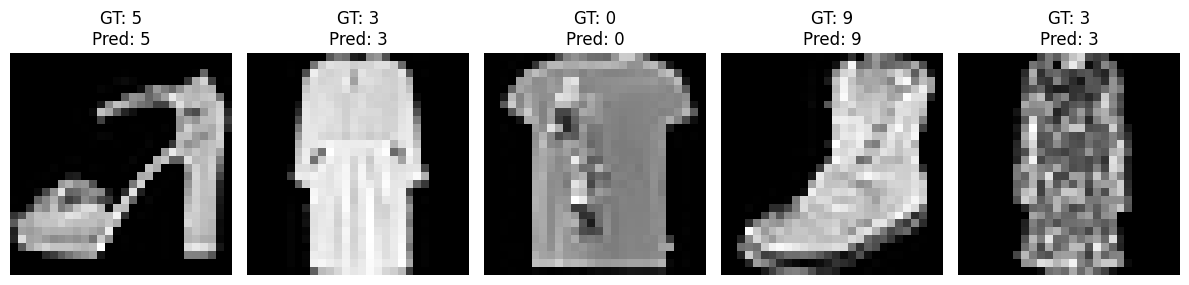

In [171]:
# 모델 준비
model = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

show_random_predictions(model, test_dataset, num_images=5)

In [173]:
print(train_dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
